In [1]:
using StanSample, Distributions, Dates
using DataFrames, CSV

In [2]:
ENV["JULIA_CMDSTAN_HOME"] = expanduser("~/cmdstan");

In [3]:
include("../src/rt-from-frequency-dynamics.jl")
using .rt_from_frequency_dynamics

In [4]:
cases_df = DataFrame(CSV.File("../data/location-case-counts.tsv"))
seq_df = DataFrame(CSV.File("../data/location-variant-sequence-counts.tsv"))

,date,location,variant,sequences
,Date,String,String,Int64
1,2021-01-02,Alabama,other,3
2,2021-01-03,Alabama,other,3
3,2021-01-04,Alabama,other,12
4,2021-01-05,Alabama,other,72
5,2021-01-06,Alabama,other,36
6,2021-01-07,Alabama,other,1
7,2021-01-08,Alabama,other,1
8,2021-01-09,Alabama,other,7
9,2021-01-10,Alabama,other,3


In [5]:
# 1. Make dataframe
loc = "Alabama"
LD = LineageData(filter(row -> row.location == loc, seq_df), filter(row -> row.location == loc, cases_df))
LD.sequence_counts

273×8 Matrix{Int64}:
 0  0  0   0  0  0  0   3
 0  0  0   0  0  0  0   3
 0  0  0   0  0  0  0  12
 0  0  0   0  0  0  0  72
 0  0  0   0  0  0  0  36
 0  0  0   0  0  0  0   1
 0  0  0   0  0  0  0   1
 0  0  0   0  0  0  0   7
 0  0  0   0  0  0  0   3
 0  0  0   0  0  0  0  17
 0  0  0   0  0  0  0   3
 0  0  0   0  0  0  0   1
 0  0  0   0  0  0  0   2
 ⋮               ⋮     
 0  0  0  37  0  0  0   0
 0  0  0  57  0  0  0   1
 0  0  0  51  0  0  0   1
 0  0  0  56  0  0  0   0
 0  0  0  43  0  0  0   0
 0  0  0  30  0  0  0   0
 0  0  0  29  0  0  0   0
 0  0  0  36  0  0  0   0
 0  0  0  33  0  0  0   0
 0  0  0  28  0  0  0   0
 0  0  0  22  0  0  0   0
 0  0  0  13  0  0  0   0

In [6]:
# 2. Get lifetimes
g, onset = get_standard_delays()

# 3. Create the model for Rt
n_days = length(unique(LD.dates))
rt_model = SplineTrend(20, n_days, 4)
priors = [["LAS"]]
seed_L = 7
forecast_L = 0

# 4. Choose lineage model type
LM =  FreeLineageModel(g, onset, rt_model, priors, seed_L, forecast_L)

FreeLineageModel{Float64}([0.0013570708164475438, 0.030252383582115523, 0.1248726218372186, 0.21989262129982626, 0.23434297788835956, 0.1800507935166118, 0.11003557415528875, 0.05680884455133395, 0.025772058657759778, 0.010556189208093536, 0.003980424684790984, 0.0014017344178233193, 0.0004660914523152426], [3.8872052302944836e-7, 0.0013781561063394194, 0.055284375808597706, 0.3417218112141225, 0.780268761669684, 1.0, 0.9014831923033185, 0.6502995817497046, 0.4056024823983106, 0.22963239715075728, 0.12180655617080503, 0.06183884788596803, 0.030491658924558254, 0.014754237581045646, 0.00705796544686744, 0.0033558114933791216, 0.0015921209508521382], SplineTrend(20, [1.0, 15.31578947368421, 29.63157894736842, 43.94736842105263, 58.26315789473684, 72.57894736842105, 86.89473684210526, 101.21052631578947, 115.52631578947368, 129.84210526315786, 144.1578947368421, 158.47368421052633, 172.78947368421052, 187.10526315789474, 201.42105263157893, 215.73684210526318, 230.05263157894737, 244.3684

In [7]:
model_dir = "../data/sims/tests"
MS = make_stan(LM, LD, "test-states", "$model_dir/test_free")


/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/tests/test_free/test-states.stan updated.


Main.rt_from_frequency_dynamics.ModelStan(SampleModel("test-states", "\nfunctions {\n  int get_L_nonzero(int[] Z, int L){\n    int L_nonzero = 0;\n    for (i in 1:L){\n      if(Z[i] > 0){ \n        L_nonzero += 1;\n      }\n    }\n    return L_nonzero;\n  }\n\n  int[] get_nonzero_idx(int[] Z, int L_nonzero, int L){\n    int cur_idx = 1;\n    int non_zero_idx[L_nonzero];\n\n    for (i in 1:L){\n      if(Z[i] > 0){\n        non_zero_idx[cur_idx] = i;\n        cur_idx += 1;\n      }\n    }\n    return non_zero_idx;\n  }\n\n\n  matrix get_weekend_mat(int L){\n        matrix[L, 7] wk_mat = rep_matrix(0, L, 7);\n        for (i in 1:L){\n           wk_mat[i, (i % 7)+1] = 1;\n        }\n        return(wk_mat);\n    }\n\n  vector get_infections(vector R, real I0, vector g_rev, int T, int l, int seed_L){\n    vector[T] I;\n    I[1:seed_L] = rep_vector(I0, seed_L);\n\n    // Loop for dates without full backlog\n    for (t in seed_L:(l-1)){\n      I[t+1] = R[t-seed_L+1] * dot_product(I[1:t], tail(

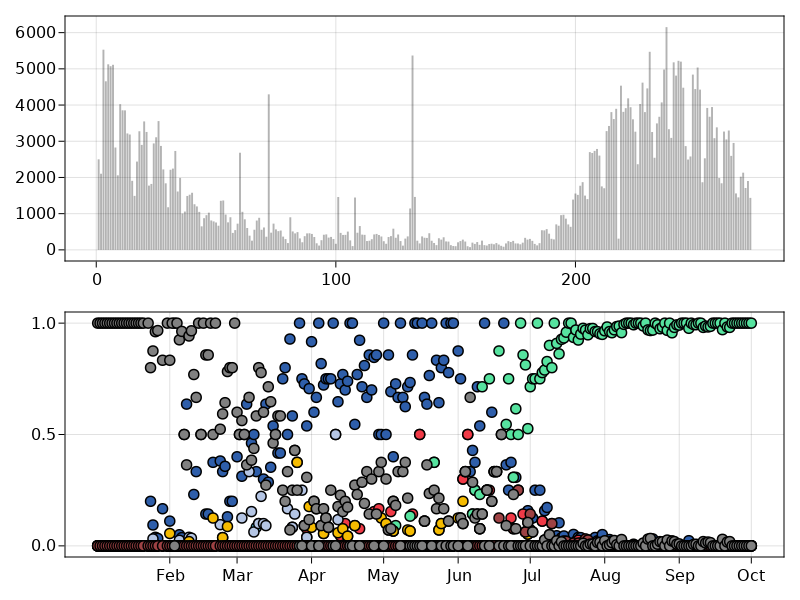

In [12]:
using CairoMakie

fig = Figure()
ax = fig[2,1] = Axis(fig)
plot_observed_frequencies!(ax, MS, size = N -> 10)
add_monthly_dates!(ax, LD.dates)

ax2 = fig[1,1] = Axis(fig)
plot_cases!(ax2, MS)
fig

In [13]:
run!(MS, num_warmup = 1000, num_samples=1000, num_chains=4, get_samples=true)

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[2] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/tests/test_free/test-states.stan', line 217, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[2] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/tests/test_free/test-states.stan', line 217, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained varia

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[14] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/tests/test_free/test-states.stan', line 217, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[35] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/tests/test_free/test-states.stan', line 217, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained var

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[2] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/tests/test_free/test-states.stan', line 217, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[3] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/tests/test_free/test-states.stan', line 217, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained varia

19433-element Vector{String}:
 "b.1.1"
 "b.2.1"
 "b.3.1"
 "b.4.1"
 "b.5.1"
 "b.6.1"
 "b.7.1"
 "b.8.1"
 "b.9.1"
 "b.10.1"
 "b.11.1"
 "b.12.1"
 "b.13.1"
 ⋮
 "obs_freqs.262.8"
 "obs_freqs.263.8"
 "obs_freqs.264.8"
 "obs_freqs.265.8"
 "obs_freqs.266.8"
 "obs_freqs.267.8"
 "obs_freqs.268.8"
 "obs_freqs.269.8"
 "obs_freqs.270.8"
 "obs_freqs.271.8"
 "obs_freqs.272.8"
 "obs_freqs.273.8"

In [14]:
colors = lineage_colors = ["#2e5eaa", "#5adbff", "#f03a47", "#56e39f","#b4c5e4",  "#f5bb00", "#9e4244", "#808080"] 

8-element Vector{String}:
 "#2e5eaa"
 "#5adbff"
 "#f03a47"
 "#56e39f"
 "#b4c5e4"
 "#f5bb00"
 "#9e4244"
 "#808080"

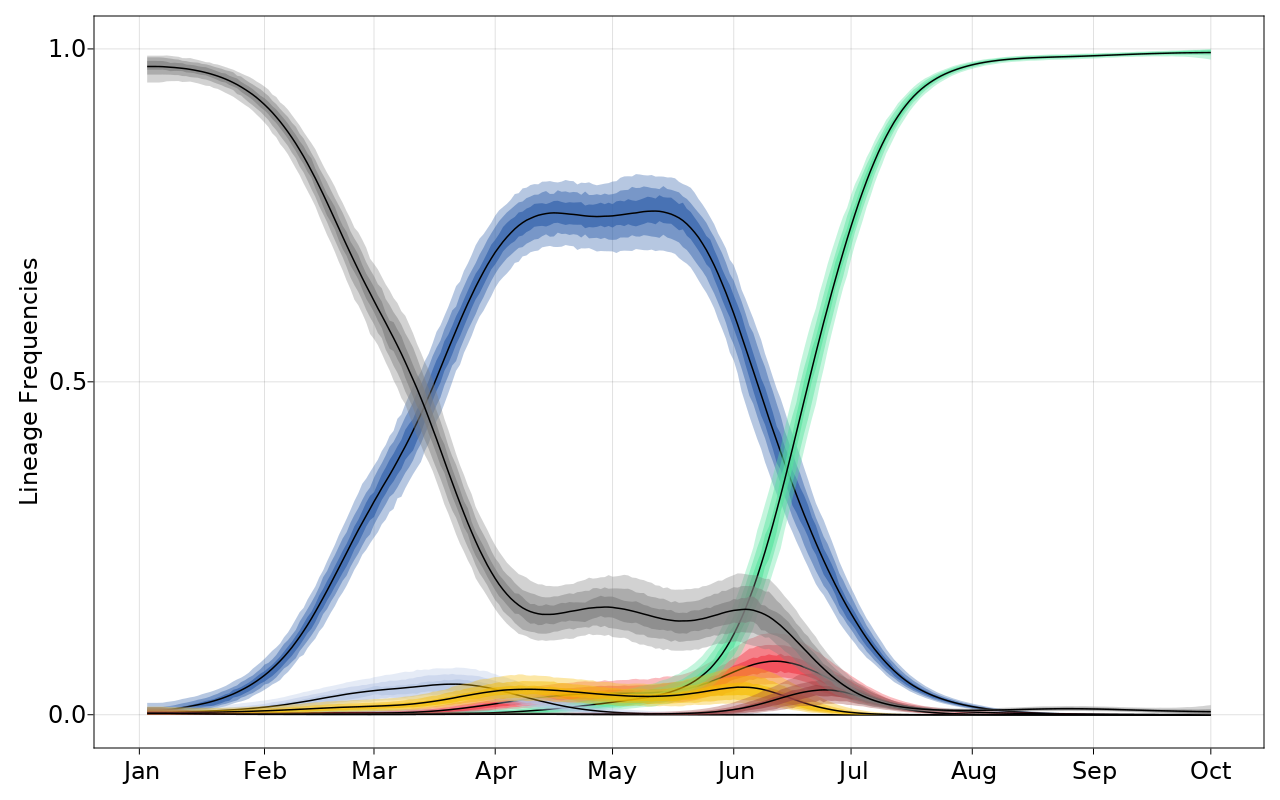

In [68]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1,1] = Axis(fig, ylabel = "Lineage Frequencies")
plot_lineage_frequency!(ax, MS)
add_monthly_dates!(ax, LD.dates)

fig

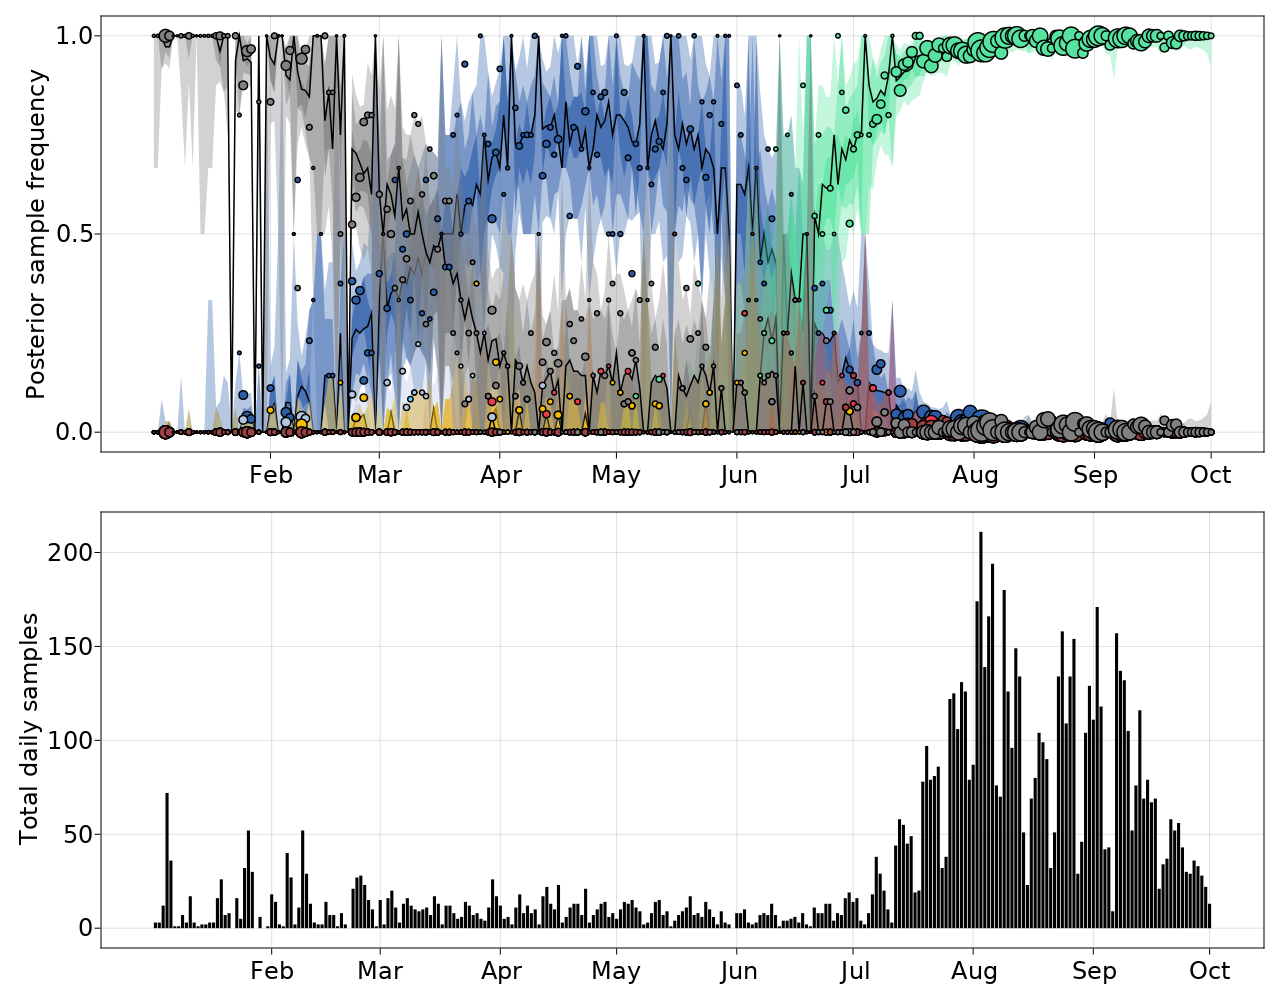

In [19]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 1000), fontsize = 24)
ax = fig[1,1] = Axis(fig, ylabel = "Posterior sample frequency")
plot_frequency_ppc!(ax, MS; colors=colors)
plot_observed_frequencies!(ax, MS; colors=colors, size = N -> 1.5*sqrt(N+1))
add_monthly_dates!(ax, LD.dates)

ax = fig[2,1] = Axis(fig, ylabel = "Total daily samples")
barplot!(ax, vec(sum(LD.sequence_counts, dims=2)), color = :black)
add_monthly_dates!(ax, LD.dates)

fig

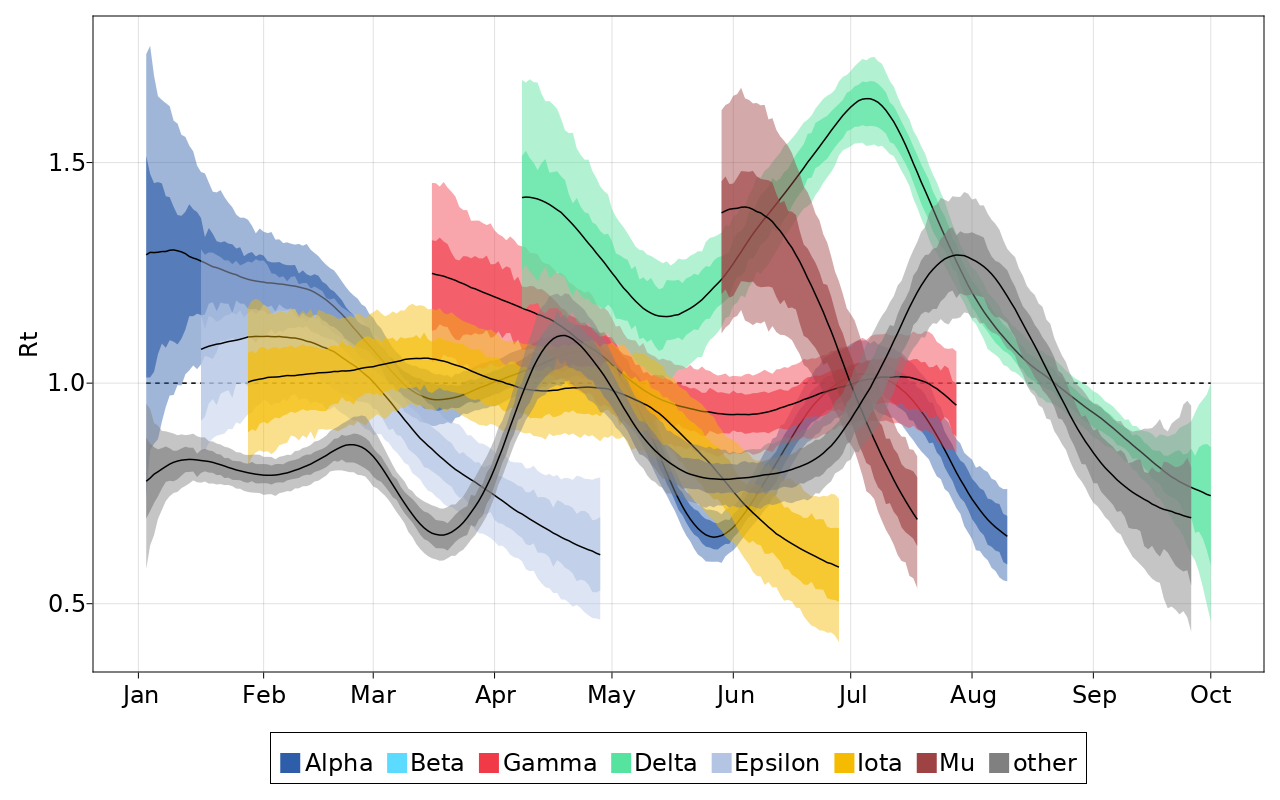

In [62]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1,1] = Axis(fig, ylabel = "Rt")
plot_lineage_R_censored!(ax, MS, colors=colors, ps = [0.5, 0.8], thres = 0.005)
add_monthly_dates!(ax, LD.dates)

elements = [PolyElement(polycolor = colors[i]) for (i,s) in enumerate(LD.seq_names)]
fig[2,1] = Legend(fig, elements, LD.seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)

fig

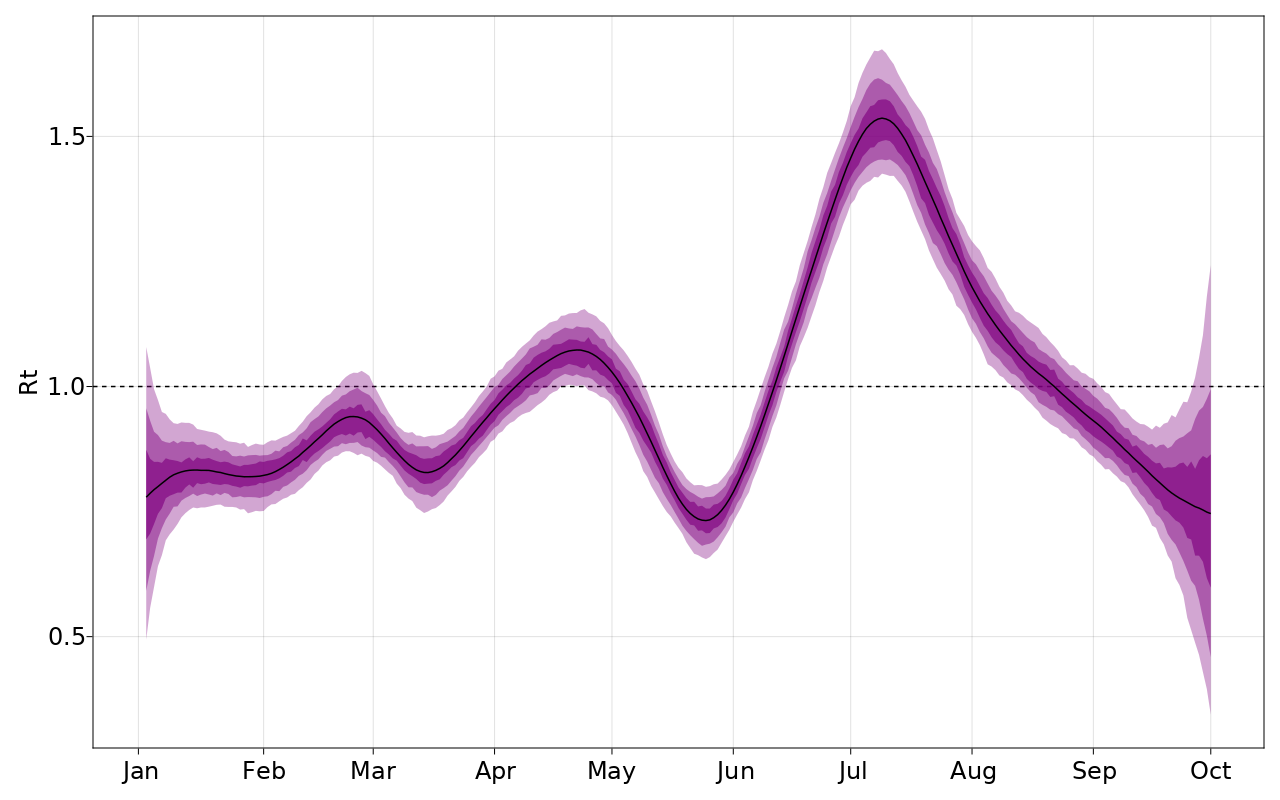

In [66]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1,1] = Axis(fig, ylabel = "Rt")
plot_average_R!(ax, MS)
add_monthly_dates!(ax, LD.dates)

fig

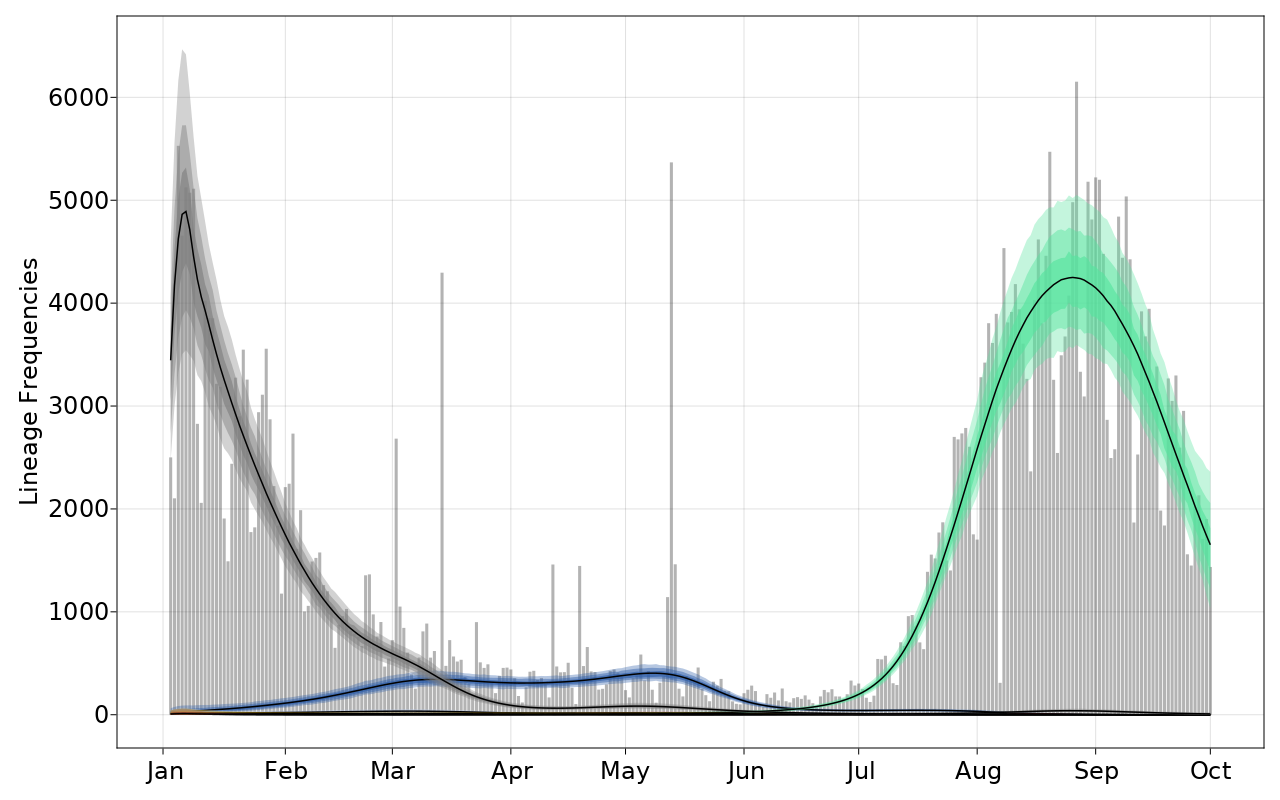

In [67]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1,1] = Axis(fig, ylabel = "Lineage Frequencies")
plot_cases!(ax, MS)
plot_lineage_prev!(ax, MS, colors=colors)
add_monthly_dates!(ax, LD.dates)

fig